# Table of Contents
1. [Load the Data](#1.-Load-the-Data)
2. [Some First Eyeballing](#2.-Some-First-Eyeballing)
3. [Data Cleaning](#3.-Data-Cleaning)
4. [Eyeballing After Cleaning](#4.-Eyeballing-After-Cleaning)
5. [Descriptive Statistics](#5.-Descriptive-Statistics)
    - [Visualize Demographics](#Visualize-Demographics-(before-and-after-cleaning))
    - [Test For Age Differences](#Test-For-Age-Differences)
    - [Test For Gender Differences](#Test-For-Gender-Differences)


6. [Statistical Analysis (finally!)](#6.-Statistical-Analysis-(finally!)) 
    - [First: Accuracy](#First:-Accuracy)
    - [Second: User Judgements from Survey](#Second:-User-Judgements-from-Survey)

# 1. Load the Data
First, we'll load all the CSV files into pandas DataFrames. We will also do some slight re-coding of the data for easier processing.

In [1]:
# Step A: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Step B: Load the data
demographics = pd.read_csv('demographics.csv')
reaction_times_instructions = pd.read_csv('reactionTimesInstructions.csv')
reaction_times_task = pd.read_csv('reactionTimesTask.csv')
survey_data = pd.read_csv('surveyData.csv')
task_performance = pd.read_csv('taskPerformance.csv')

# Step C: task performance, re-code Y to 1 and N to 0, add accuracy
task_performance['userPred'] = task_performance['userPred'].map({'Y': 1, 'N': 0})
task_performance['truePred'] = task_performance['truePred'].map({'Y': 1, 'N': 0})
task_performance['accuracy'] = (task_performance['userPred'] == task_performance['truePred']).astype(int)

# Step D: Define a consistent color palette for consistent plotting
color_palette = {
    's-cfe': '#1f77b4',  # blue
    'o-cfe': '#ff7f0e',  # orange
    's-con': '#2ca02c',  # green
    'o-con': '#d62728'   # red
}

# Convert the palette to a list of colors
colors = [color_palette[key] for key in color_palette]

# 2. Some First Eyeballing

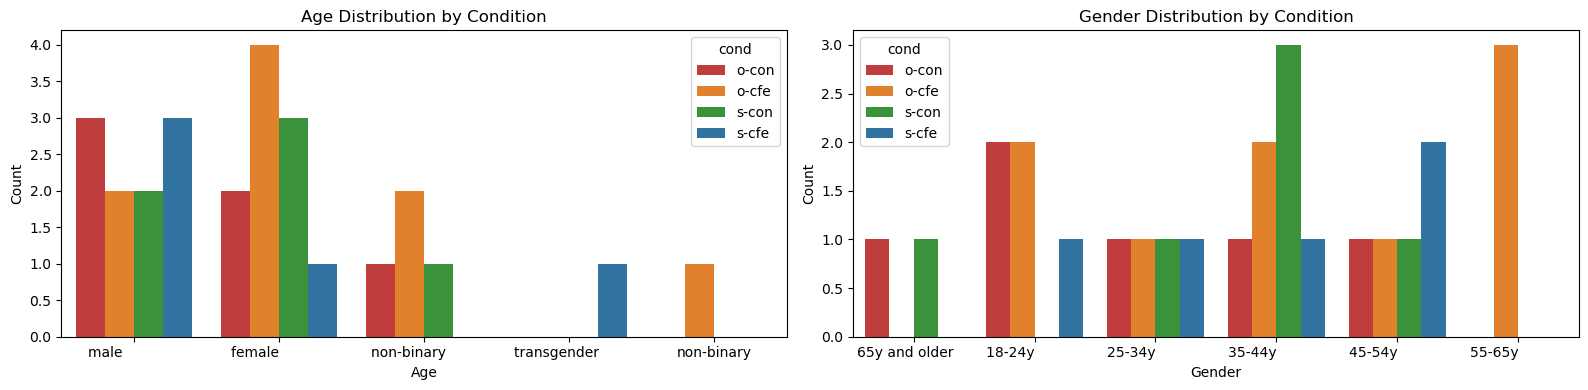

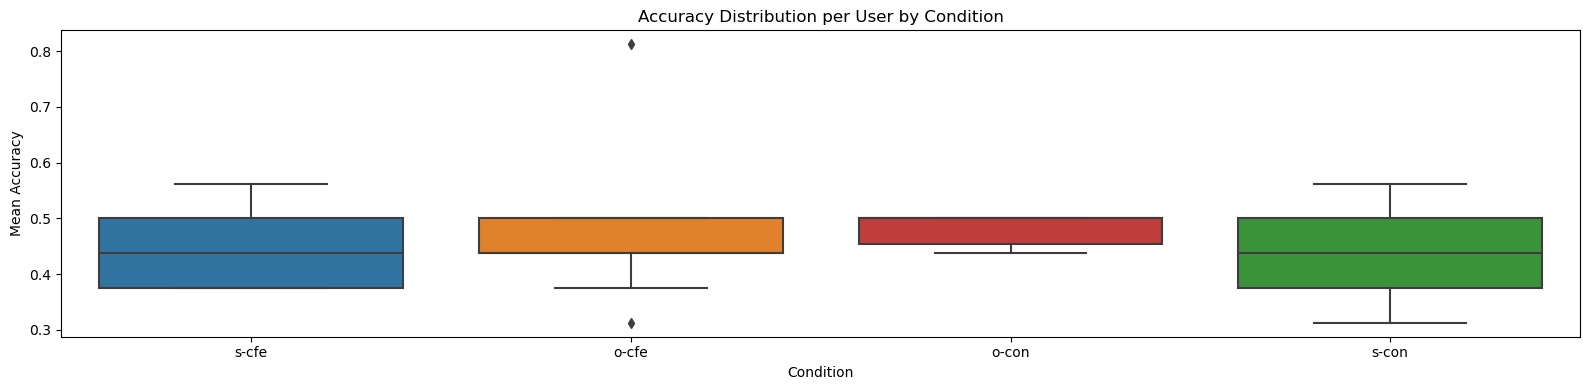

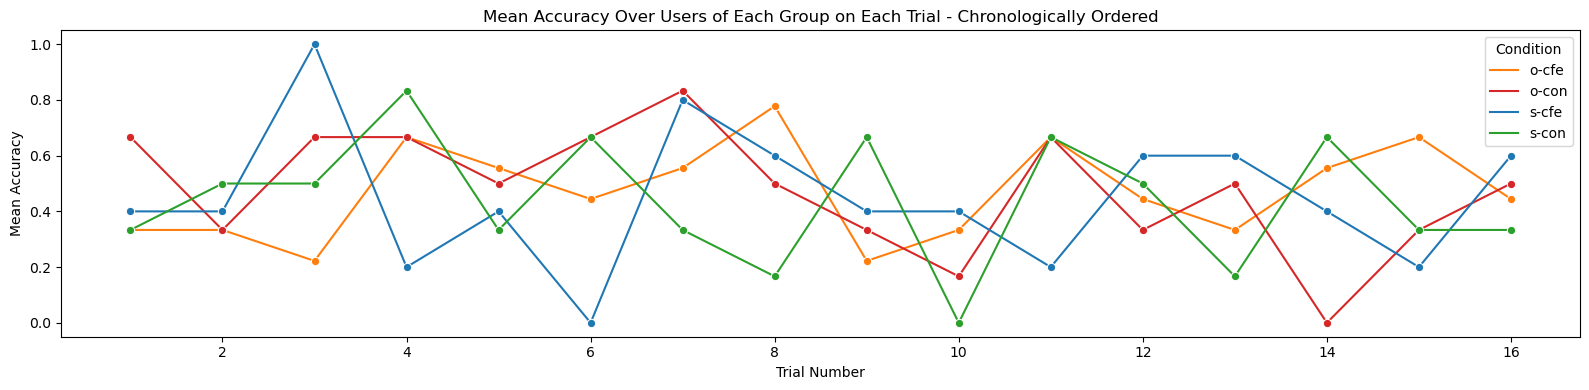

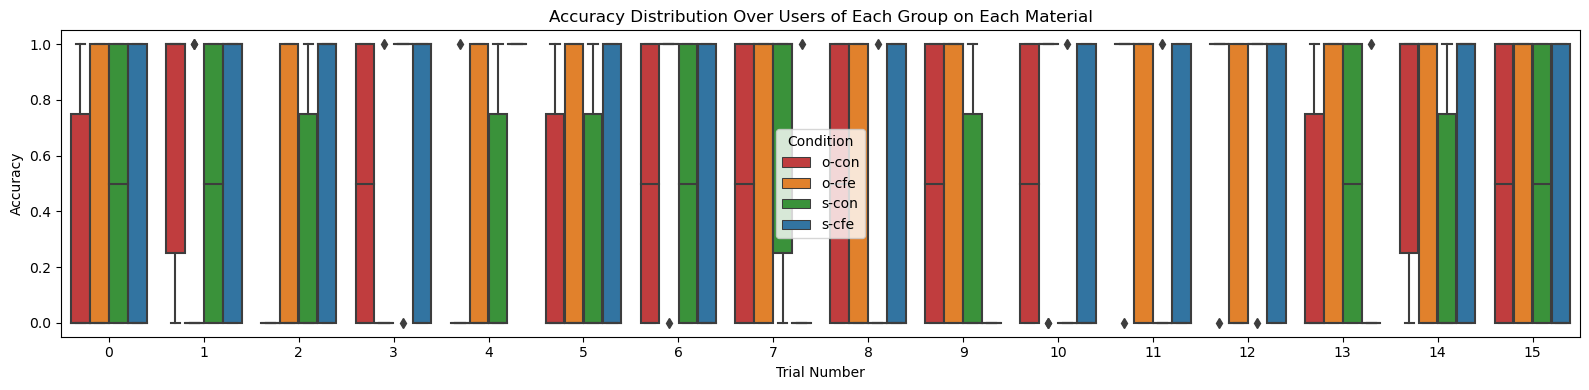

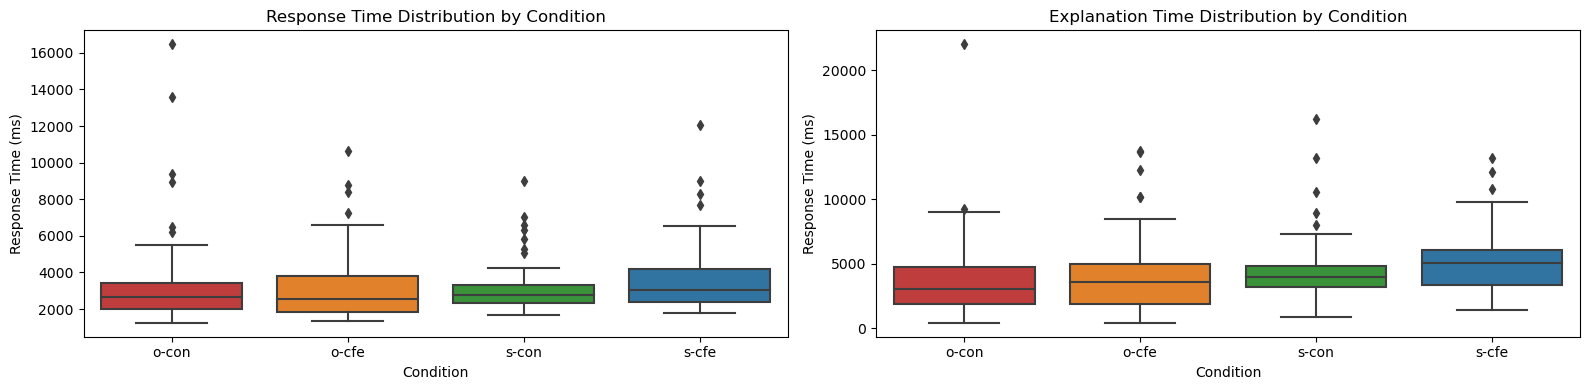

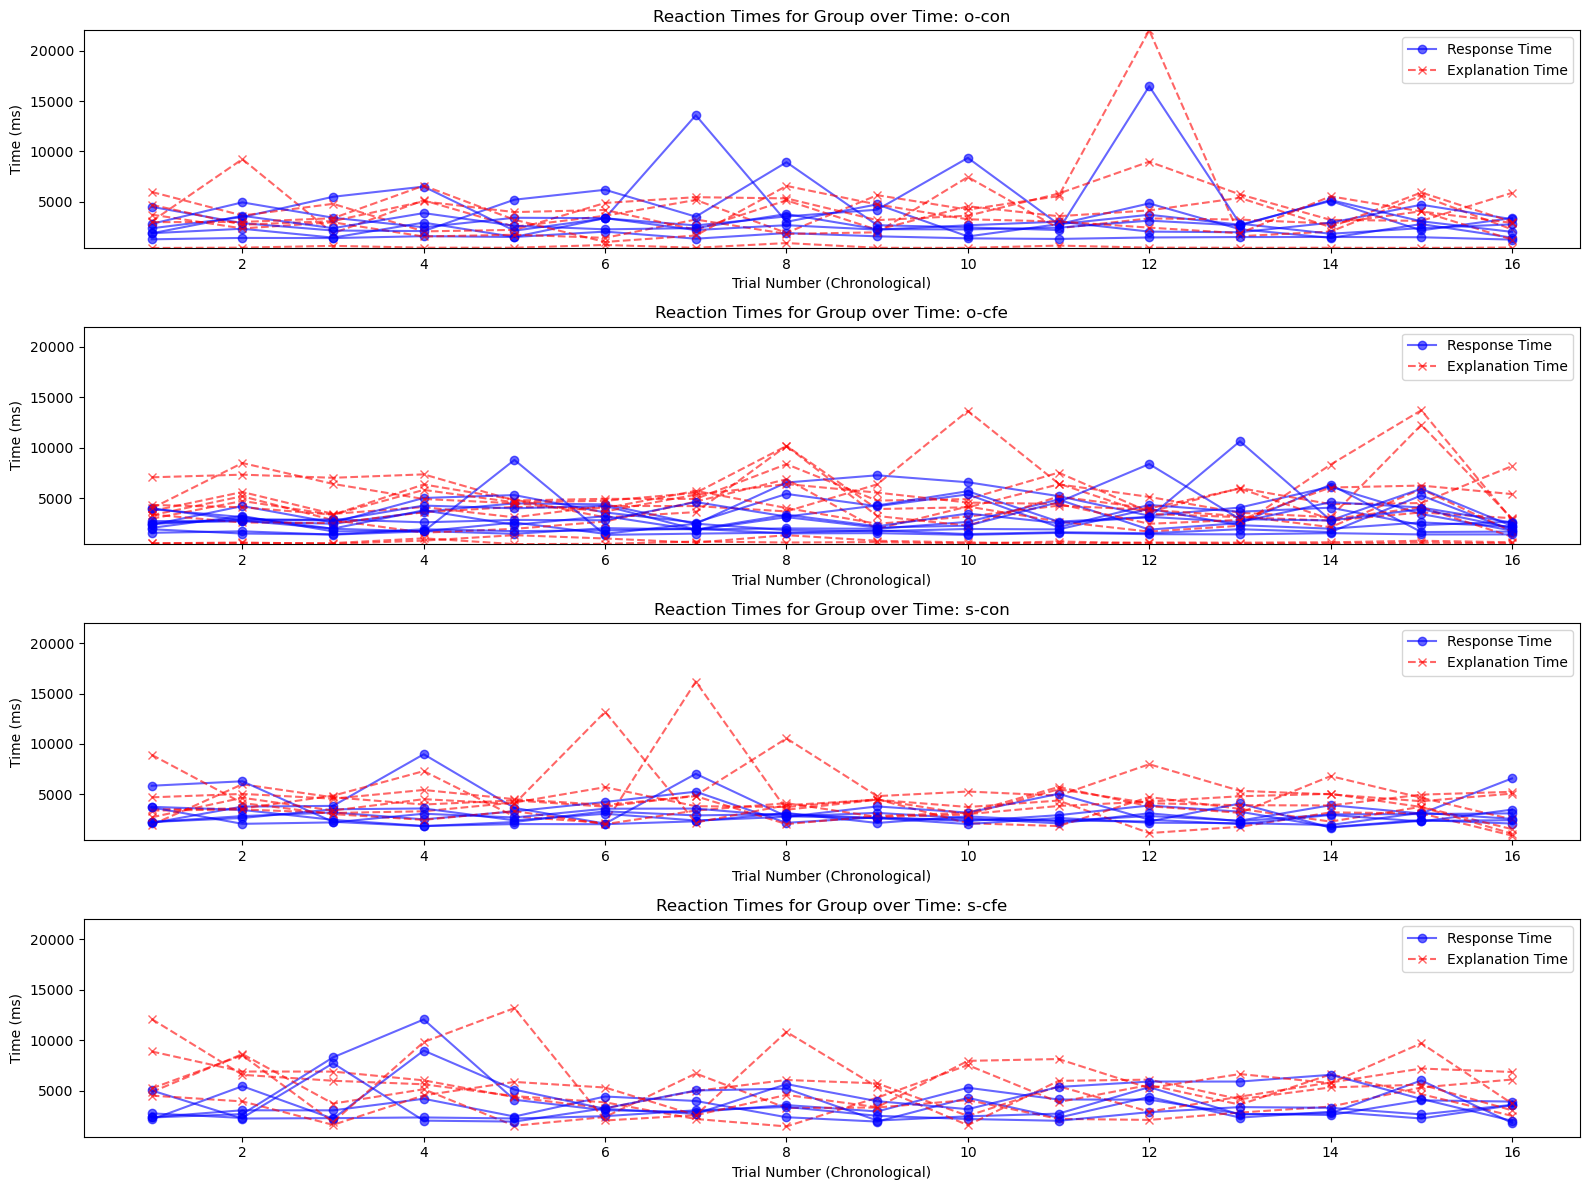

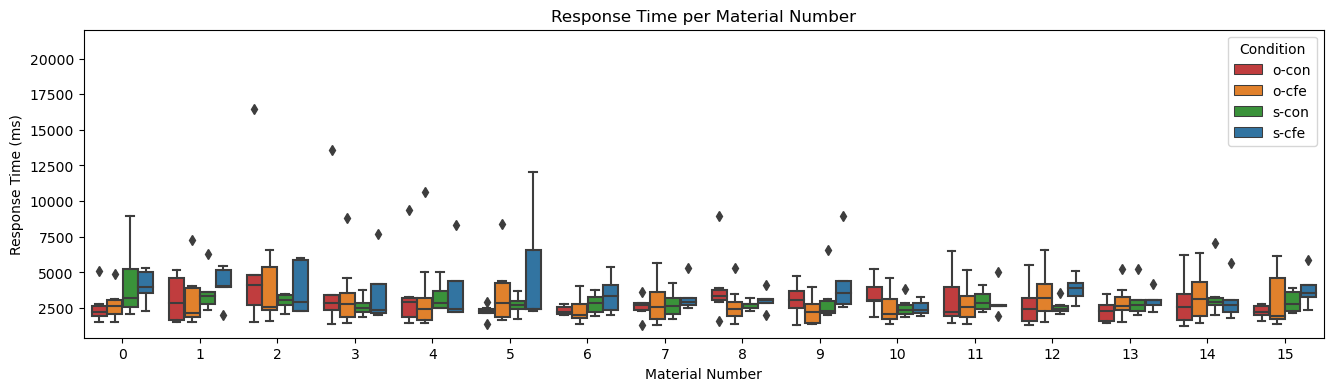

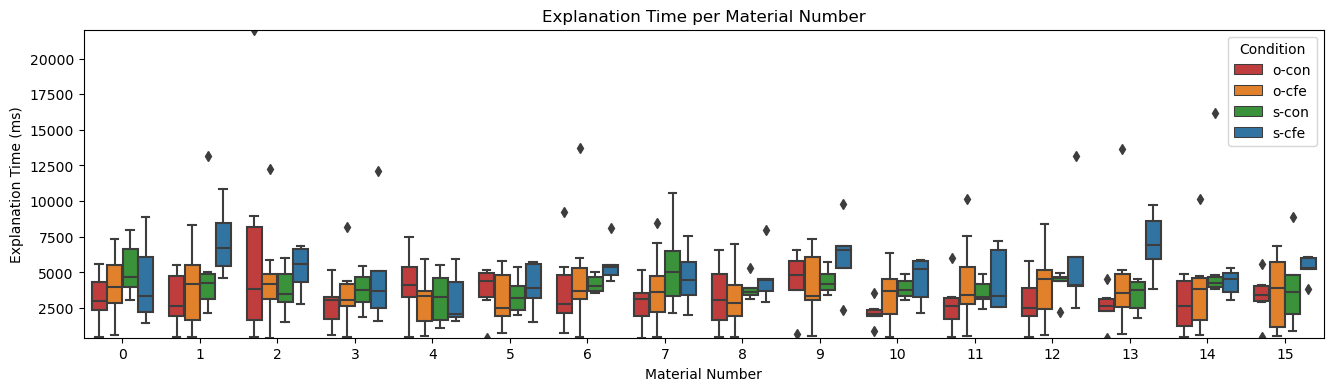

In [2]:
# Initial plotting for eye-balling the data
plt.figure(figsize=(16, 4))

# Plot Age distribution
plt.subplot(1, 2, 1)
sns.countplot(data=demographics, x='age', hue='cond',palette=color_palette)
plt.title('Age Distribution by Condition')
plt.xlabel('Age')
plt.ylabel('Count')

# Plot Gender distribution
plt.subplot(1, 2, 2)
sns.countplot(data=demographics, x='gender', hue='cond',palette=color_palette)
plt.title('Gender Distribution by Condition')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Look at Accuracy
# add a column 'orderedTrial' reflecting the temporal order of trials per participant
task_performance = task_performance.copy()
task_performance['orderedTrial'] = task_performance.groupby('userID').cumcount() + 1

plt.figure(figsize=(16, 4))
# Plot Mean Accuracy distribution
# Compute mean accuracy and merge with demographics for plotting
mean_accuracy_per_user = task_performance.groupby('userID')['accuracy'].mean().reset_index()
mean_accuracy_per_user = mean_accuracy_per_user.merge(demographics, on='userID')
# Plot Mean Accuracy per user
sns.boxplot(data=mean_accuracy_per_user, x='cond', y='accuracy',palette=color_palette)
plt.title('Accuracy Distribution per User by Condition')
plt.xlabel('Condition')
plt.tight_layout()
plt.ylabel('Mean Accuracy')
plt.show()

plt.figure(figsize=(16, 4))
# Plot Mean Accuracy over users of each group over time
# (= trials chronologically ordered, to eyeball effects related to the duration of the study, fatigue, etc.)
mean_performance_per_trial = task_performance.groupby(['cond', 'orderedTrial']).agg({'accuracy': 'mean'}).reset_index()
sns.lineplot(data=mean_performance_per_trial, x='orderedTrial', y='accuracy', hue='cond', marker='o',palette=color_palette)
plt.title('Mean Accuracy Over Users of Each Group on Each Trial - Chronologically Ordered')
plt.xlabel('Trial Number')
plt.ylabel('Mean Accuracy')
plt.legend(title='Condition')
#plt.show()
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 4))
# Plot Mean Accuracy over users of each group on each material as boxplots, add's stats info
sns.boxplot(data=task_performance, x='trialNo', y='accuracy', hue='cond',palette=color_palette)
plt.title('Accuracy Distribution Over Users of Each Group on Each Material')
plt.xlabel('Trial Number')
plt.ylabel('Accuracy')
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

# Look at Reaction Times
# add a column 'orderedTrial' reflecting the temporal order of trials per participant
reaction_times_task = reaction_times_task.copy()
reaction_times_task['orderedTrial'] = reaction_times_task.groupby('userID').cumcount() + 1

plt.figure(figsize=(16, 4))
# Plot Reaction Times
plt.subplot(1, 2, 1)
sns.boxplot(data=reaction_times_task, x='cond', y='responseTime',palette=color_palette)
plt.title('Response Time Distribution by Condition')
plt.xlabel('Condition')
plt.ylabel('Response Time (ms)')

# Plot Reaction Times
plt.subplot(1, 2, 2)
sns.boxplot(data=reaction_times_task, x='cond', y='explanationTime',palette=color_palette)
plt.title('Explanation Time Distribution by Condition')
plt.xlabel('Condition')
plt.ylabel('Response Time (ms)')
plt.tight_layout()
plt.show()

# Plot reaction times per user, divided into groups for more visibility
plt.figure(figsize=(16, 12))
groups = reaction_times_task['cond'].unique()
response_time_min = reaction_times_task['responseTime'].min()
response_time_max = reaction_times_task['responseTime'].max()
explanation_time_min = reaction_times_task['explanationTime'].min()
explanation_time_max = reaction_times_task['explanationTime'].max()

# Trials Chronologically Ordered, to Eyeball Effects Related to the Duration of the Study, Fatigue, etc.)
for i, group in enumerate(groups, 1):
    plt.subplot(len(groups), 1, i)
    subset = reaction_times_task[reaction_times_task['cond'] == group]
    for user in subset['userID'].unique():
        user_data = subset[subset['userID'] == user]
        plt.plot(user_data['orderedTrial'], user_data['responseTime'], marker='o', linestyle='-', color='blue', alpha=0.6)
        plt.plot(user_data['orderedTrial'], user_data['explanationTime'], marker='x', linestyle='--', color='red', alpha=0.6)
    plt.title(f'Reaction Times for Group over Time: {group}')
    plt.xlabel('Trial Number (Chronological)')
    plt.ylabel('Time (ms)')
    plt.ylim(min(response_time_min, explanation_time_min), max(response_time_max, explanation_time_max))
    plt.legend(['Response Time', 'Explanation Time'], loc='upper right')
plt.tight_layout()
plt.show()

# Plot Response Time per Material divided by group (to spot Effects Related to Materials)
plt.figure(figsize=(16, 4))
sns.boxplot(x='trialNo', y='responseTime', hue='cond', data=reaction_times_task, palette=color_palette)
plt.title('Response Time per Material Number')
plt.xlabel('Material Number')
plt.ylabel('Response Time (ms)')
plt.ylim(min(response_time_min, explanation_time_min), max(response_time_max, explanation_time_max))
plt.legend(title='Condition')
plt.show()

# Plot Explanation Time per Material divided by group (to spot Effects Related to Materials)
plt.figure(figsize=(16, 4))
sns.boxplot(x='trialNo', y='explanationTime', hue='cond', data=reaction_times_task, palette=color_palette)
plt.title('Explanation Time per Material Number')
plt.xlabel('Material Number')
plt.ylabel('Explanation Time (ms)')
plt.ylim(min(response_time_min, explanation_time_min), max(response_time_max, explanation_time_max))
plt.legend(title='Condition')
plt.show()


# 3. Data Cleaning
Next, we'll clean the data based on pre-defined criteria. Specifically, we want to remove:

- all speedsters  >3 SDs below the mean​
- all materials  >3 SDs from mean​
- materials >3 SDs from person‘s own mean, to catch attention failures​
- straight-liners, repeatedly giving same answer, even with negative feedback​
- non-varying responses


In [3]:
# Define a function for removing outliers
def identify_outliers(df, column):
    # define the factor with which std will be multiplied to find admissible range
    removal_factor_population=3
    print("\nMeasure: " + column)
    print("Population mean: " + str(round(df[column].mean(),3)))
    print("Population std: " + str(round(df[column].std(),3)))
    print("Admissible range: " + str(round(df[column].mean()-removal_factor_population * df[column].std())) + " -- " + str(round(df[column].mean()+removal_factor_population * df[column].std())))
    #outliers = df[np.abs(df[column] - df[column].mean()) > (3 * df[column].std())]
    outliers = df[df[column] < (df[column].mean() - removal_factor_population * df[column].std())]
    return outliers['userID'].unique()

# Identify speedsters: >3 SDs from population mean
outliers_reaction_times_instructions = set()
for column in ['timeConsentPage', 'timeInstruct1', 'timeInstruct2', 'timeAttentionCheck']:
    outliers_reaction_times_instructions.update(identify_outliers(reaction_times_instructions, column))

outliers_reaction_times_task = set()
for column in ['responseTime', 'explanationTime']:
    outliers_reaction_times_task.update(identify_outliers(reaction_times_task, column))
    
print("\nUserIDs of speedsters relative to all participants (instructions) :" + str(outliers_reaction_times_instructions))
print("UserIDs of speedsters relative to all participants (task) :" + str(outliers_reaction_times_task))

# Identify straightliners (repeatedly giving the same answer) from survey data
straightliners_survey = survey_data.groupby('userID').filter(lambda x: (x['responseNo'].var() == 0))
print("\nUserIDs of straightliners during survey: " + str(straightliners_survey['userID'].unique()))

# Identify straightliners (repeatedly giving the same answer) from task data
straightliners_task = task_performance.groupby('userID').filter(lambda x: (x['userPred'].var() == 0))
print("UserIDs of straightliners during task: " + str(straightliners_task['userID'].unique()))

# Identify attention failure in instruction (wrong answer to first question)
attention_failures_instruction = reaction_times_instructions[(reaction_times_instructions['responseAttentionCheck-pass2'] == 0)]['userID'].unique()
print("UserIDs of attention failures during instructions: " + str(attention_failures_instruction))

# Identify attention failure in survey (wrong answer to question X)
attention_failures_survey = survey_data[(survey_data['itemNo'] == 5) & (survey_data['checked'] != 1) & (survey_data['responseNo'] == 2)]['userID'].unique()
print("UserIDs of attention failures during survey: " + str(attention_failures_survey))


Measure: timeConsentPage
Population mean: 22184.538
Population std: 59662.859
Admissible range: -156804 -- 201173

Measure: timeInstruct1
Population mean: 8804.154
Population std: 5563.538
Admissible range: -7886 -- 25495

Measure: timeInstruct2
Population mean: 11053.577
Population std: 4852.851
Admissible range: -3505 -- 25612

Measure: timeAttentionCheck
Population mean: 8412.577
Population std: 3706.713
Admissible range: -2708 -- 19533

Measure: responseTime
Population mean: 3157.178
Population std: 1754.717
Admissible range: -2107 -- 8421

Measure: explanationTime
Population mean: 4059.113
Population std: 2577.644
Admissible range: -3674 -- 11792

UserIDs of speedsters relative to all participants (instructions) :set()
UserIDs of speedsters relative to all participants (task) :set()

UserIDs of straightliners during survey: []
UserIDs of straightliners during task: [94184206 95973901 37115631]
UserIDs of attention failures during instructions: [73585152]
UserIDs of attention fail

In [4]:
# Combine all population outliers
all_outliers = outliers_reaction_times_instructions.union(outliers_reaction_times_task).union(straightliners_survey['userID'].unique()).union(straightliners_task['userID'].unique()).union(attention_failures_survey).union(attention_failures_instruction)

print("UserIDs of all outliers: " + str(all_outliers))
print("N: " + str(len(all_outliers)))

UserIDs of all outliers: {59994992, 73585152, 15418525, 95973901, 94184206, 37115631}
N: 6


In [5]:
# Remove population outliers from all datasets
reaction_times_instructions_cleaned = reaction_times_instructions[~reaction_times_instructions['userID'].isin(all_outliers)]
reaction_times_task_cleaned = reaction_times_task[~reaction_times_task['userID'].isin(all_outliers)]
task_performance_cleaned = task_performance[~task_performance['userID'].isin(all_outliers)]
survey_data_cleaned = survey_data[~survey_data['userID'].isin(all_outliers)]
demographics_cleaned = demographics[~demographics['userID'].isin(all_outliers)]

Next, we will also look at the materials: are there any that are systematically answered unusually quickly?

In [7]:
# Identify wonky materials: RTs >3 SDs from person‘s own mean
# Define the factor with which std will be multiplied to find the admissible range
removal_factor_user_wise = 3
wonky_trial_user_percentage = 30

# Identify trials (=materials) where users performed more quickly than > 3SD from their own RT mean
response_time_outliers = reaction_times_task_cleaned[
    reaction_times_task_cleaned['responseTime'] < (
        reaction_times_task_cleaned.groupby('userID')['responseTime'].transform('mean') - 
        removal_factor_user_wise * reaction_times_task_cleaned.groupby('userID')['responseTime'].transform('std')
    )
]

explanation_time_outliers = reaction_times_task_cleaned[
    reaction_times_task_cleaned['explanationTime'] < (
        reaction_times_task_cleaned.groupby('userID')['explanationTime'].transform('mean') - 
        removal_factor_user_wise * reaction_times_task_cleaned.groupby('userID')['explanationTime'].transform('std')
    )
]

# Display the outliers for responseTime and explanationTime
print("\nUserIDs + trialNo of speedsters relative to own performance (response time):")
print(response_time_outliers[['userID', 'trialNo', 'responseTime']])

print("\nUserIDs + trialNo of speedsters relative to own performance (explanation time):")
print(explanation_time_outliers[['userID', 'trialNo', 'explanationTime']])

# Combine the outliers into a single DataFrame for analysis
outliers_combined = pd.concat([
    response_time_outliers[['userID', 'trialNo']],
    explanation_time_outliers[['userID', 'trialNo']]
]).drop_duplicates()

# Calculate the percentage of outliers for each trialNo(=material)
outlier_percentage = outliers_combined['trialNo'].value_counts(normalize=True) * 100

# Identify trialNo(=material) where at least 30% of participants were quicker than > 3 SDs of their own performance
wonky_trials = outlier_percentage[outlier_percentage >= wonky_trial_user_percentage].index.tolist()

print("\nList of trialNo where at least 30% of participants were quicker than > 3 SDs of their own performance:")
print(wonky_trials)

# Show specifics of wonky_trials (=material)
fields = ["trialNo", "truePred", "valQuality", "valProductivity", "valPunctuality", "valFeedback"]
wonky_trials_df = task_performance_cleaned[task_performance_cleaned['trialNo'].isin(wonky_trials)].groupby('trialNo').head(1)[fields]
print("\nSpecifics of wonky materials:")
print(wonky_trials_df)


# Filter out wonky trials from the dataframes - CAREFUL! LIKELY BREAKS BALANCE OF TRIALS!
#def remove_wonky_trials(df, wonky_trials):
#    return df[~df['trialNo'].isin(wonky_trials)]
# Remove wonky trials from all relevant dataframes
#reaction_times_task_cleaned = remove_wonky_trials(reaction_times_task_cleaned, wonky_trials)
#task_performance_cleaned = remove_wonky_trials(task_performance_cleaned, wonky_trials)


UserIDs + trialNo of speedsters relative to own performance (response time):
Empty DataFrame
Columns: [userID, trialNo, responseTime]
Index: []

UserIDs + trialNo of speedsters relative to own performance (explanation time):
Empty DataFrame
Columns: [userID, trialNo, explanationTime]
Index: []

List of trialNo where at least 30% of participants were quicker than > 3 SDs of their own performance:
[]

Specifics of wonky materials:
Empty DataFrame
Columns: [trialNo, truePred, valQuality, valProductivity, valPunctuality, valFeedback]
Index: []


# 4. Eyeballing After Cleaning

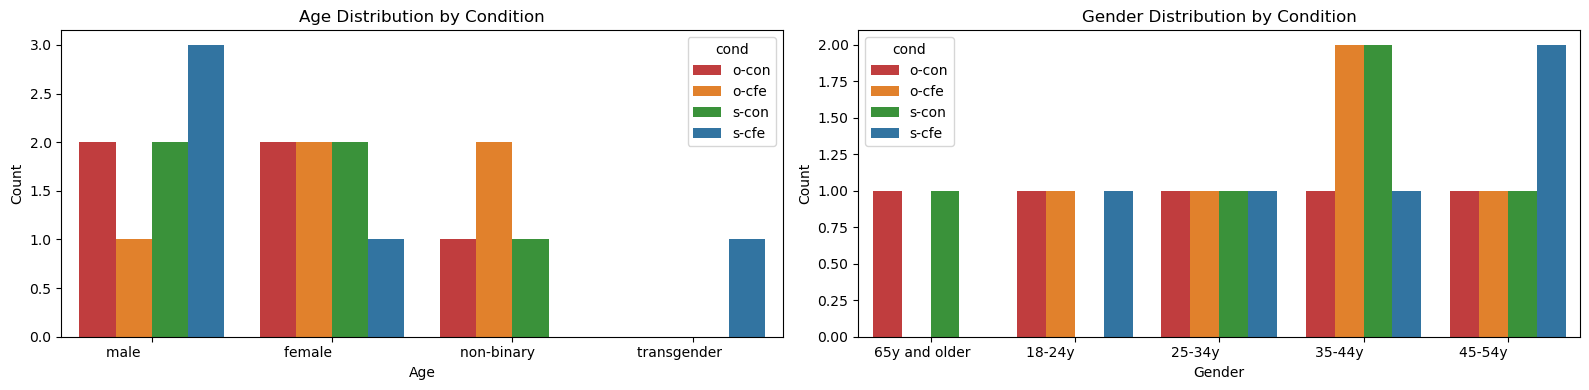

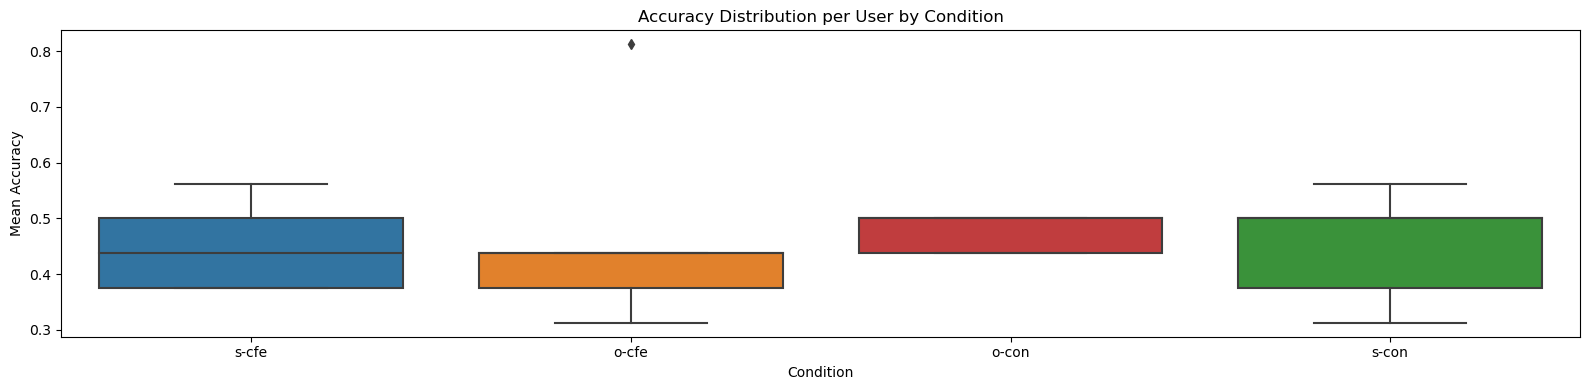

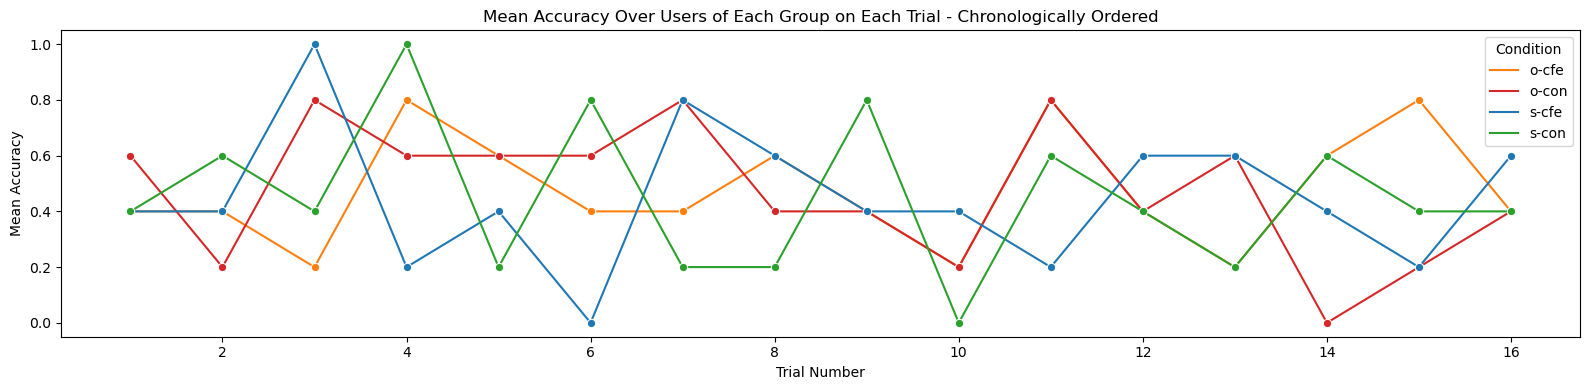

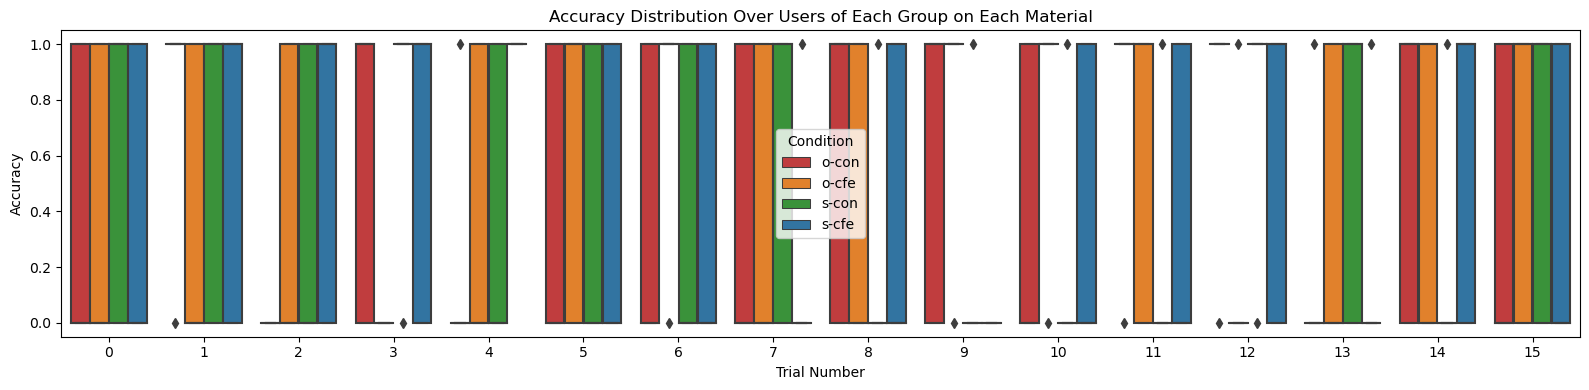

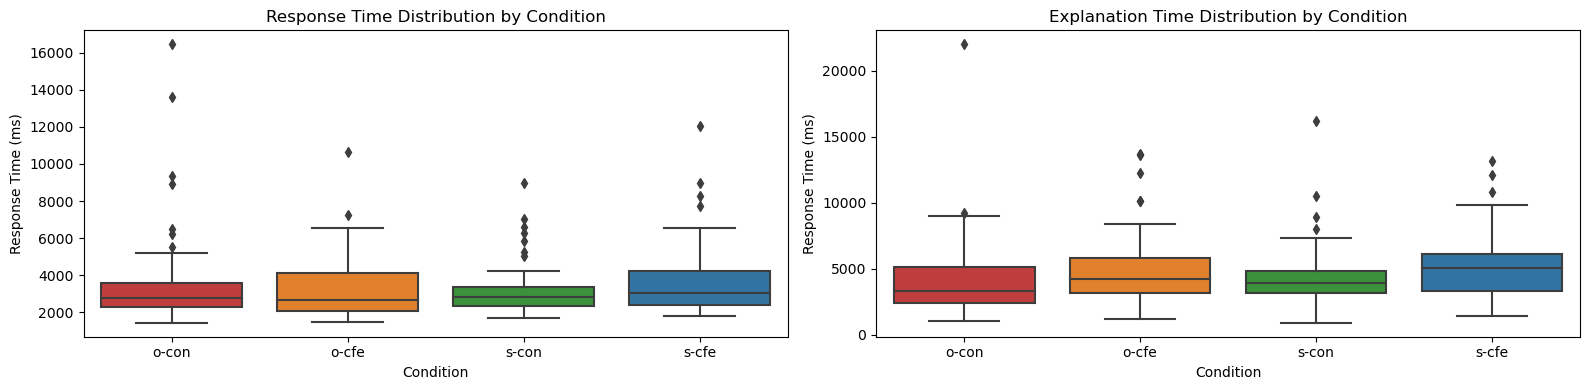

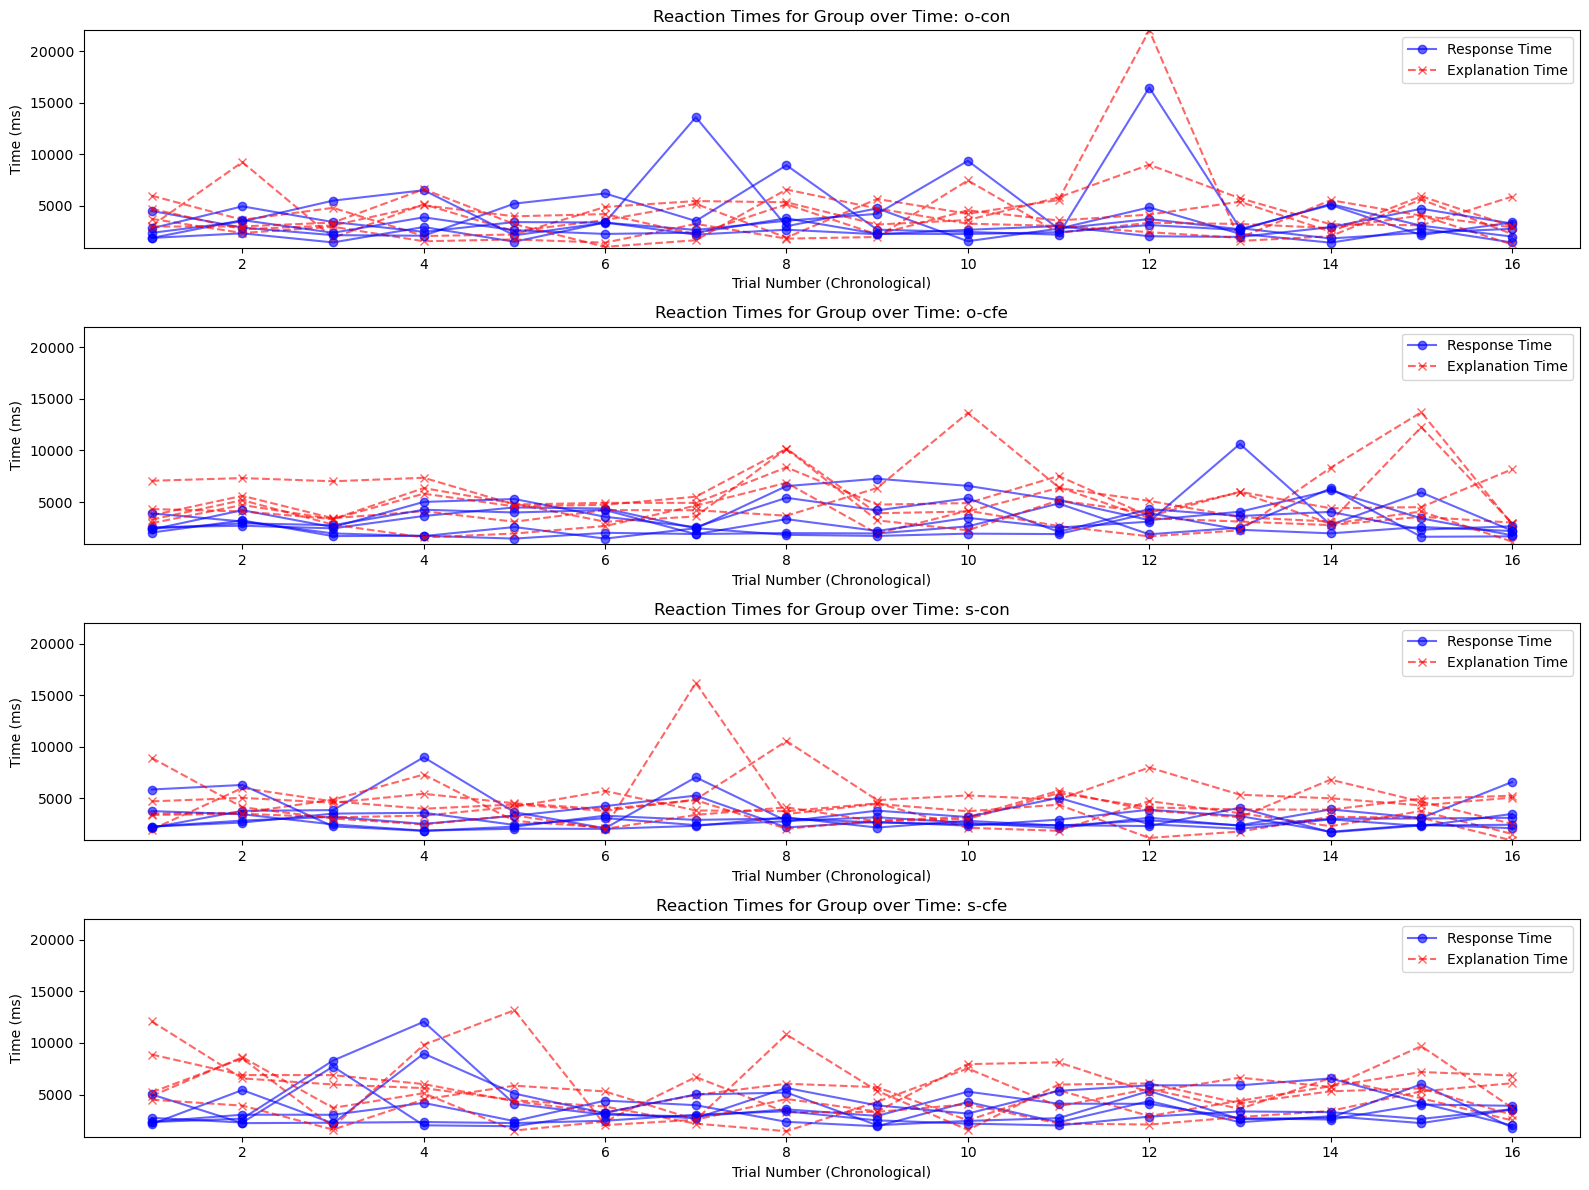

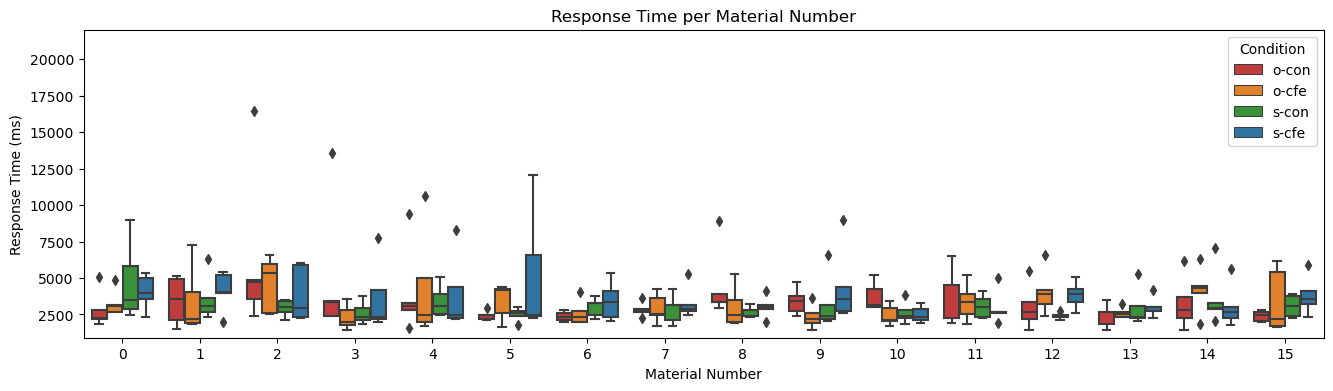

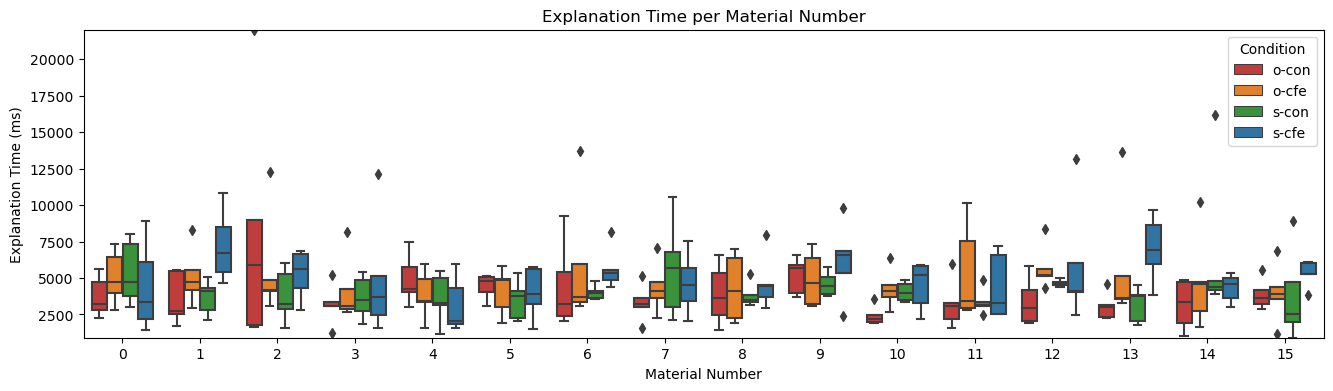

In [8]:
# Initial plotting for eye-balling the data
plt.figure(figsize=(16, 4))

# Plot Age distribution
plt.subplot(1, 2, 1)
sns.countplot(data=demographics_cleaned, x='age', hue='cond', palette=color_palette)
plt.title('Age Distribution by Condition')
plt.xlabel('Age')
plt.ylabel('Count')

# Plot Gender distribution
plt.subplot(1, 2, 2)
sns.countplot(data=demographics_cleaned, x='gender', hue='cond', palette=color_palette)
plt.title('Gender Distribution by Condition')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Look at Accuracy
# add a column 'orderedTrial' reflecting the temporal order of trials per participant
task_performance_cleaned = task_performance_cleaned.copy()
task_performance_cleaned['orderedTrial'] = task_performance_cleaned.groupby('userID').cumcount() + 1

plt.figure(figsize=(16, 4))
# Plot Mean Accuracy distribution
# Compute mean accuracy and merge with demographics for plotting
mean_accuracy_per_user_cleaned = task_performance_cleaned.groupby('userID')['accuracy'].mean().reset_index()
mean_accuracy_per_user_cleaned = mean_accuracy_per_user_cleaned.merge(demographics_cleaned, on='userID')
# Plot Mean Accuracy per user
sns.boxplot(data=mean_accuracy_per_user_cleaned, x='cond', y='accuracy', palette=color_palette)
plt.title('Accuracy Distribution per User by Condition')
plt.xlabel('Condition')
plt.tight_layout()
plt.ylabel('Mean Accuracy')
plt.show()

plt.figure(figsize=(16, 4))
# Plot Mean Accuracy over users of each group over time
# (= trials chronologically ordered, to eyeball effects related to the duration of the study, fatigue, etc.)
mean_performance_per_trial_cleaned = task_performance_cleaned.groupby(['cond', 'orderedTrial']).agg({'accuracy': 'mean'}).reset_index()
sns.lineplot(data=mean_performance_per_trial_cleaned, x='orderedTrial', y='accuracy', hue='cond', marker='o', palette=color_palette)
plt.title('Mean Accuracy Over Users of Each Group on Each Trial - Chronologically Ordered')
plt.xlabel('Trial Number')
plt.ylabel('Mean Accuracy')
plt.legend(title='Condition')
#plt.show()
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 4))
# Plot Mean Accuracy over users of each group on each material as boxplots, add's stats info
sns.boxplot(data=task_performance_cleaned, x='trialNo', y='accuracy', hue='cond', palette=color_palette)
plt.title('Accuracy Distribution Over Users of Each Group on Each Material')
plt.xlabel('Trial Number')
plt.ylabel('Accuracy')
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

# Look at Reaction Times
# add a column 'orderedTrial' reflecting the temporal order of trials per participant
reaction_times_task_cleaned = reaction_times_task_cleaned.copy()
reaction_times_task_cleaned['orderedTrial'] = reaction_times_task_cleaned.groupby('userID').cumcount() + 1

plt.figure(figsize=(16, 4))
# Plot Reaction Times
plt.subplot(1, 2, 1)
sns.boxplot(data=reaction_times_task_cleaned, x='cond', y='responseTime', palette=color_palette)
plt.title('Response Time Distribution by Condition')
plt.xlabel('Condition')
plt.ylabel('Response Time (ms)')

# Plot Reaction Times
plt.subplot(1, 2, 2)
sns.boxplot(data=reaction_times_task_cleaned, x='cond', y='explanationTime', palette=color_palette)
plt.title('Explanation Time Distribution by Condition')
plt.xlabel('Condition')
plt.ylabel('Response Time (ms)')
plt.tight_layout()
plt.show()

# Plot reaction times per user, divided into groups for more visibility
plt.figure(figsize=(16, 12))
groups = reaction_times_task_cleaned['cond'].unique()
response_time_min = reaction_times_task_cleaned['responseTime'].min()
response_time_max = reaction_times_task_cleaned['responseTime'].max()
explanation_time_min = reaction_times_task_cleaned['explanationTime'].min()
explanation_time_max = reaction_times_task_cleaned['explanationTime'].max()

# Trials Chronologically Ordered, to Eyeball Effects Related to the Duration of the Study, Fatigue, etc.)
for i, group in enumerate(groups, 1):
    plt.subplot(len(groups), 1, i)
    subset = reaction_times_task_cleaned[reaction_times_task_cleaned['cond'] == group]
    for user in subset['userID'].unique():
        user_data = subset[subset['userID'] == user]
        plt.plot(user_data['orderedTrial'], user_data['responseTime'], marker='o', linestyle='-', color='blue', alpha=0.6)
        plt.plot(user_data['orderedTrial'], user_data['explanationTime'], marker='x', linestyle='--', color='red', alpha=0.6)
    plt.title(f'Reaction Times for Group over Time: {group}')
    plt.xlabel('Trial Number (Chronological)')
    plt.ylabel('Time (ms)')
    plt.ylim(min(response_time_min, explanation_time_min), max(response_time_max, explanation_time_max))
    plt.legend(['Response Time', 'Explanation Time'], loc='upper right')
plt.tight_layout()
plt.show()

# Plot Response Time per Material divided by group (to spot Effects Related to Materials)
plt.figure(figsize=(16, 4))
sns.boxplot(x='trialNo', y='responseTime', hue='cond', data=reaction_times_task_cleaned, palette=color_palette)
plt.title('Response Time per Material Number')
plt.xlabel('Material Number')
plt.ylabel('Response Time (ms)')
plt.ylim(min(response_time_min, explanation_time_min), max(response_time_max, explanation_time_max))
plt.legend(title='Condition')
plt.show()

# Plot Explanation Time per Material divided by group (to spot Effects Related to Materials)
plt.figure(figsize=(16, 4))
sns.boxplot(x='trialNo', y='explanationTime', hue='cond', data=reaction_times_task_cleaned, palette=color_palette)
plt.title('Explanation Time per Material Number')
plt.xlabel('Material Number')
plt.ylabel('Explanation Time (ms)')
plt.ylim(min(response_time_min, explanation_time_min), max(response_time_max, explanation_time_max))
plt.legend(title='Condition')
plt.show()

# 5. Descriptive Statistics
We'll compute descriptive statistics for the demographics and check if groups are significantly different in terms of age and gender.

## Visualize Demographics (before and after cleaning)


Summary of the number of participants in each group:
    cond  Number of Participants
0  o-cfe                       5
1  o-con                       5
2  s-cfe                       5
3  s-con                       5


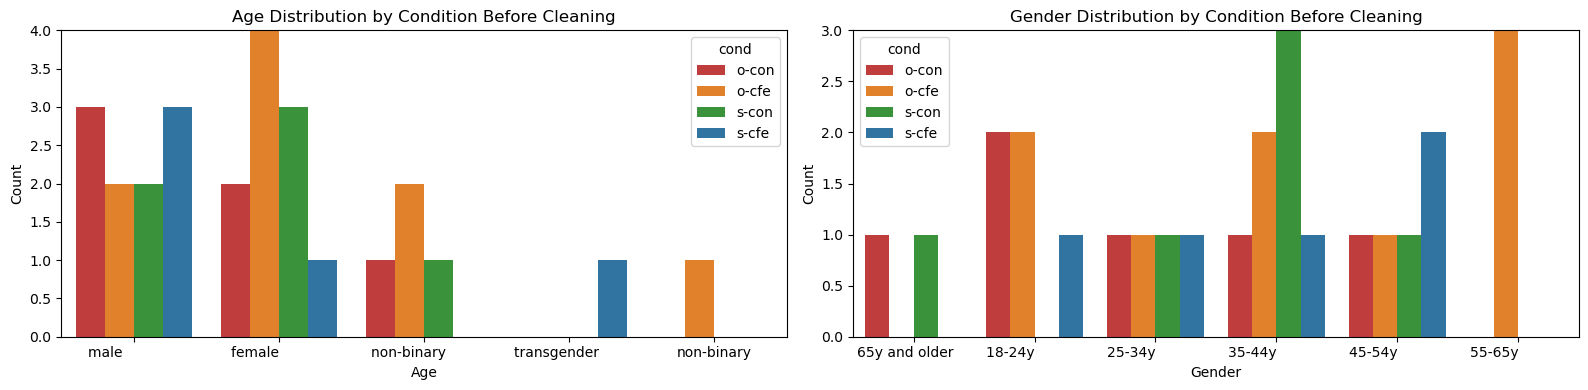

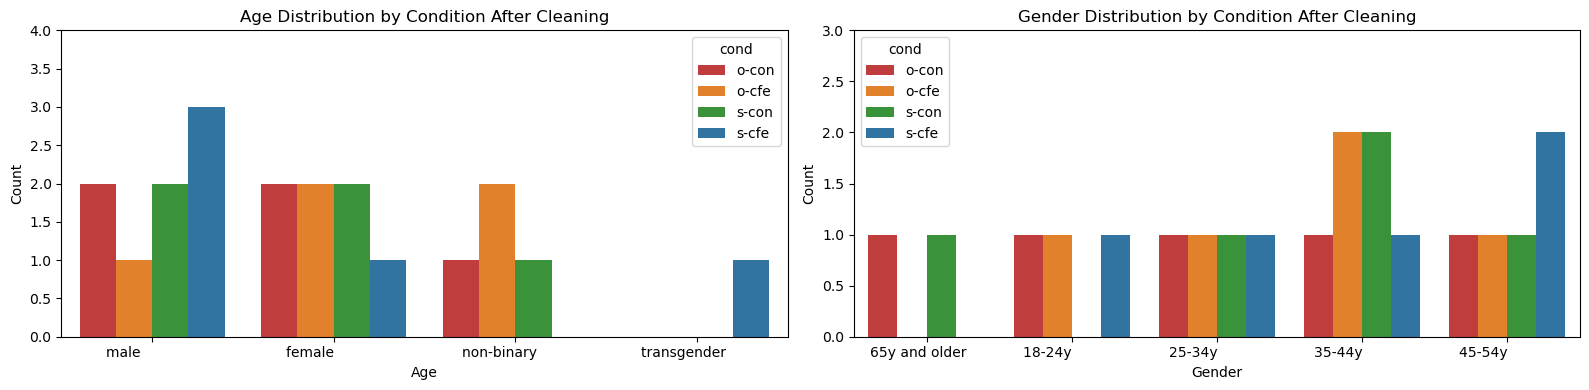

In [11]:
# Provide a summary of the number of participants in each group
participant_summary = demographics_cleaned.groupby('cond').size().reset_index(name='Number of Participants')

print("\nSummary of the number of participants in each group:")
print(participant_summary)

# make some plots:
# for uniform axes, get the frequency distribution of age / gender groups by condition
age_distribution_by_cond = demographics.groupby(['cond', 'age']).size().reset_index(name='count')
gender_distribution_by_cond = demographics.groupby(['cond', 'gender']).size().reset_index(name='count')

# Find the maximal frequency for age groups by condition
max_age_count = max(age_distribution_by_cond.loc[age_distribution_by_cond.groupby('cond')['count'].idxmax()]['count'])
# Find the maximal frequency for gender groups by condition
max_gender_count = max(gender_distribution_by_cond.loc[gender_distribution_by_cond.groupby('cond')['count'].idxmax()]['count'])

# Find the maximal frequency for age groups by condition
max_age_count = max(age_distribution_by_cond.loc[age_distribution_by_cond.groupby('cond')['count'].idxmax()]['count'])
# Find the maximal frequency for gender groups by condition
max_gender_count = max(gender_distribution_by_cond.loc[gender_distribution_by_cond.groupby('cond')['count'].idxmax()]['count'])

# Plot: Before data cleaning
plt.figure(figsize=(16, 4))

# Plot Age distribution
plt.subplot(1, 2, 1)
sns.countplot(data=demographics, x='age', hue='cond',palette=color_palette)
plt.title('Age Distribution by Condition Before Cleaning')
plt.xlabel('Age')
plt.ylabel('Count')
plt.ylim(0, max_age_count)

# Plot Gender distribution
plt.subplot(1, 2, 2)
sns.countplot(data=demographics, x='gender', hue='cond',palette=color_palette)
plt.title('Gender Distribution by Condition Before Cleaning')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.ylim(0, max_gender_count)

plt.tight_layout()
plt.show()

# Plot: After data cleaning
plt.figure(figsize=(16, 4))

# Plot Age distribution
plt.subplot(1, 2, 1)
sns.countplot(data=demographics_cleaned, x='age', hue='cond',palette=color_palette)
plt.title('Age Distribution by Condition After Cleaning')
plt.xlabel('Age')
plt.ylabel('Count')
plt.ylim(0, max_age_count)

# Plot Gender distribution
plt.subplot(1, 2, 2)
sns.countplot(data=demographics_cleaned, x='gender', hue='cond',palette=color_palette)
plt.title('Gender Distribution by Condition After Cleaning')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.ylim(0, max_gender_count)

plt.tight_layout()
plt.show()

## Test For Age Differences

In [12]:
from scipy.stats import kruskal
import scikit_posthocs as sp

# Perform Kruskal-Wallis H Test for age distributions across conditions
groups = [demographics_cleaned[demographics_cleaned['cond'] == cond]['age'] for cond in demographics_cleaned['cond'].unique()]
kruskal_test_result = kruskal(*groups)

# Calculate Eta-Squared (η²)
H = kruskal_test_result.statistic
k = len(groups)
n = len(demographics)
eta_squared = (H - k + 1) / (n - 1)

print("Kruskal-Wallis H Test for Age Distributions:")
print(f"H-Statistic: {round(kruskal_test_result.statistic,3)}, p-value: {round(kruskal_test_result.pvalue,3)}")
print(f"Eta-Squared (η²) Effect Size: {abs(round(eta_squared,3))}")
print("\nNote about effect size Eta-squared η²: it indicates the proportion of the total variance of the dependent variable that can be explained by the independent variable. I.e., η² means that 20% of the variation observed in groups can be explained by age.")

# If the Kruskal-Wallis H test is significant, perform post hoc test: Dunn's Test
if kruskal_test_result.pvalue < 0.05:
    p_values_dunn_age = sp.posthoc_dunn(demographics_cleaned, val_col='age', group_col='cond', p_adjust='bonferroni')
    print("Post Hoc Comparisons using Dunn's Test with Bonferroni Correction:")
    print(p_values_dunn_age)

Kruskal-Wallis H Test for Age Distributions:
H-Statistic: 0.464, p-value: 0.927
Eta-Squared (η²) Effect Size: 0.101

Note about effect size Eta-squared η²: it indicates the proportion of the total variance of the dependent variable that can be explained by the independent variable. I.e., η² means that 20% of the variation observed in groups can be explained by age.


## Test For Gender Differences

In [13]:
from scipy.stats import chi2_contingency, chi2, norm, shapiro, levene, kruskal
import itertools
import statsmodels.stats.multitest as smm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Chi-Square Test of Independence for Gender Distributions
contingency_table = pd.crosstab(demographics_cleaned['cond'], demographics_cleaned['gender'])
chi2_test_result = chi2_contingency(contingency_table)

print("Chi^2 Test of Independence for Gender Distributions:")
print(f"Chi^2 Statistic: {round(chi2_test_result[0],3)}, p-value: {round(chi2_test_result[1],3)}")
# if p > 0.05, H0 holds: we can assume that there is no dependence between age_group and condition

# Function to perform pairwise z-tests for proportions, for potential post-hoc comparisons
def pairwise_z_test(count1, nobs1, count2, nobs2):
    prop1 = count1 / nobs1
    prop2 = count2 / nobs2
    prop_pool = (count1 + count2) / (nobs1 + nobs2)
    se_pool = (prop_pool * (1 - prop_pool) * (1/nobs1 + 1/nobs2)) ** 0.5
    z_stat = (prop1 - prop2) / se_pool
    p_value = 2 * norm.cdf(-abs(z_stat))
    return p_value

# If the chi-square test is significant, perform post hoc tests
if chi2_test_result[1] < 0.05:
    # Generate all pairwise comparisons
    comparisons = list(itertools.combinations(contingency_table.index, 2))
    
    p_values = []
    for (group1, group2) in comparisons:
        for gender in contingency_table.columns:
            count1 = contingency_table.loc[group1, gender]
            count2 = contingency_table.loc[group2, gender]
            nobs1 = contingency_table.loc[group1].sum()
            nobs2 = contingency_table.loc[group2].sum()
            p_val = pairwise_z_test(count1, nobs1, count2, nobs2)
            p_values.append(p_val)
            print(f"Comparison {group1} vs {group2} for gender {gender}: p-value = {p_val}")
    
    # Adjust p-values for multiple comparisons using the Bonferroni correction
    reject, pvals_corrected, _, _ = smm.multipletests(p_values, alpha=0.05, method='bonferroni')
    
    # Display adjusted p-values
    for (group1, group2), p_val_corr in zip(comparisons, pvals_corrected):
        print(f"Adjusted p-value for {group1} vs {group2}: {p_val_corr}")

Chi^2 Test of Independence for Gender Distributions:
Chi^2 Statistic: 4.267, p-value: 0.978


# 6. Statistical Analysis (finally!)
We'll analyze the accuracy of prediction and the mean feature importances for each group.

## First: Accuracy 

We will kick-off with the accuracy for group first. Initially, we planned to run a 2x2 ANOVA to compare mean performance of all groups. However, we have to keep in mind that ANOVA has two important assumptions: data needs to normally distributed and the variances need to be homogeneous. If these assumptions are not met, it is wiser to run the non-parametric alternative: Kruskal-Wallis H Test.

Here is the plan: 

1. Plot the accuracies again to remember the distributions.
2. Check Assumptions: Normality (Shapiro-Wilk test) and Homogeneity of Variances (Levene's test).
3. Perform ANOVA if assumptions are met.
4. If only normality is violated, perform ART ANOVA.
5. If both normality and homoscedasticity are violated, perform Kruskal-Wallis H Test.

### Step 1: Plot again to refresh our memory

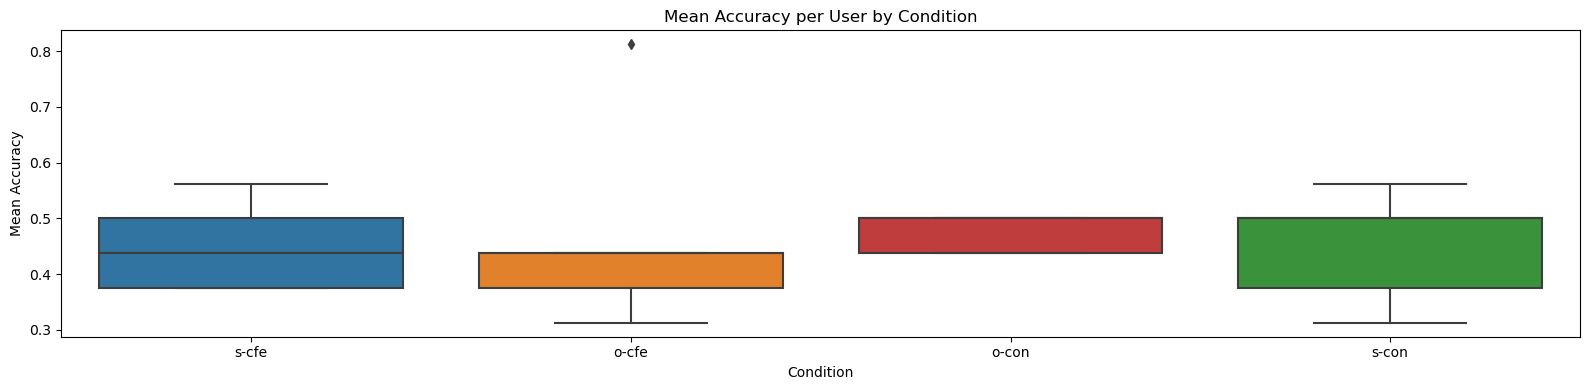

In [14]:
plt.figure(figsize=(16, 4))
# Plot Accuracy distribution
# Plot Mean Accuracy per user
sns.boxplot(data=mean_accuracy_per_user_cleaned, x='cond', y='accuracy',palette=color_palette)
plt.title('Mean Accuracy per User by Condition')
plt.xlabel('Condition')
#plt.tight_layout()
plt.ylabel('Mean Accuracy')
plt.tight_layout()
plt.show()

### Step 2: Check Assumptions

In [15]:
# Check Normality using Shapiro-Wilk test (if p<0.05, assume data is NOT normal)
normality_results = task_performance_cleaned.groupby('cond')['accuracy'].apply(shapiro)
normality_passed = all(p.pvalue > 0.05 for p in normality_results)
print("Shapiro-Wilk Test for Normality:")
for cond, result in normality_results.items():
    print(f"Condition {cond}: W-statistic = {round(result.statistic,3)}, p-value = {round(result.pvalue,3)}")

# Check Homogeneity of Variances using Levene's test (if p<0.05, assume data is NOT homoscedastic)
levene_stat, levene_pvalue = levene(*[task_performance_cleaned[task_performance_cleaned['cond'] == cond]['accuracy'] for cond in task_performance_cleaned['cond'].unique()])
homogeneity_passed = levene_pvalue > 0.05
print(f"\nLevene's Test for Homogeneity of Variances: Statistic = {round(levene_stat,3)}, p-value = {round(levene_pvalue,3)}")

Shapiro-Wilk Test for Normality:
Condition o-cfe: W-statistic = 0.636, p-value = 0.0
Condition o-con: W-statistic = 0.636, p-value = 0.0
Condition s-cfe: W-statistic = 0.633, p-value = 0.0
Condition s-con: W-statistic = 0.633, p-value = 0.0

Levene's Test for Homogeneity of Variances: Statistic = 0.066, p-value = 0.978


If normality is violated, but data is homoscedastic, we can run an ART ANOVA (Aligned Rank Transform ANOVA). We will use some R packages for this. The following takes care that everything is properly installed. Note: ignore the red output unless there is a specific warning message; that's pretty common in R even if everything is okay. X-)

In [18]:
# for ART ANOVA, might be needed later    
import contextlib
import os
# Suppress R[write to console] output
if not normality_passed and homogeneity_passed:
    utils = rpackages.importr('utils')

    # Suppress R-specific output to avoid confusions:
    with contextlib.redirect_stdout(open(os.devnull, 'w')), contextlib.redirect_stderr(open(os.devnull, 'w')):
        utils.chooseCRANmirror(ind=1)  # select the first mirror in the list
        # Install the ARTool package
        utils.install_packages('ARTool')

### Step 3-5: Perform ANOVA if assumptions are met, ART ANOVA if partially met, & Kruskal-Wallis H Test otherwise

In [22]:
from rpy2 import robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

## Generate "referent" column filled with the first letter of the "cond" field
#task_performance_cleaned.loc[:, 'referent'] = task_performance_cleaned['cond'].str[0]
## Generate "exp" column filled with everything after the "-" in the "cond" field
#task_performance_cleaned.loc[:, 'exp'] = task_performance_cleaned['cond'].str.split('-').str[1]

# Generate "referent" and "exp" columns using assign to avoid SettingWithCopyWarning
task_performance_cleaned = task_performance_cleaned.assign(
    referent=task_performance_cleaned['cond'].str[0],
    exp=task_performance_cleaned['cond'].str.split('-').str[1]
)

# Convert "referent" and "exp" columns to categorical type in Python
task_performance_cleaned['referent'] = task_performance_cleaned['referent'].astype('category')
task_performance_cleaned['exp'] = task_performance_cleaned['exp'].astype('category')

if normality_passed and homogeneity_passed:
    # Perform 2x2 ANOVA
    model = ols('accuracy ~ C(referent) * C(exp)', data=task_performance_cleaned).fit()
    anova_results = anova_lm(model)
    print("ANOVA Results:")
    print(round(anova_results,3))
    
    # Perform post hoc test if ANOVA is significant
    if anova_results["PR(>F)"][0] < 0.05:
        posthoc_result = sp.posthoc_tukey(task_performance_cleaned, val_col='accuracy', group_col='cond')
        print("\nPost Hoc Comparisons using Tukey's HSD:")
        print(round(posthoc_result,3))

#''' 
elif not normality_passed and homogeneity_passed:
    # Suppress R-specific output to avoid confusions:
    with contextlib.redirect_stdout(open(os.devnull, 'w')), contextlib.redirect_stderr(open(os.devnull, 'w')):
        # Enable the conversion between pandas DataFrames and R data frames
        pandas2ri.activate()
        # Convert columns to factors and prepare data for R
        task_performance_cleaned_r = pandas2ri.py2rpy(task_performance_cleaned)
        task_performance_cleaned_r = robjects.r['data.frame'](task_performance_cleaned_r)
        robjects.r.assign("task_performance_cleaned_r", task_performance_cleaned_r)
        
        robjects.r('''
            task_performance_cleaned_r$referent <- as.factor(task_performance_cleaned_r$referent)
            task_performance_cleaned_r$exp <- as.factor(task_performance_cleaned_r$exp)
        ''')
        
        # Perform ART ANOVA using ARTool in R
        art = importr('ARTool')
        task_performance_cleaned_r = pandas2ri.py2rpy(task_performance_cleaned)
        
        formula = robjects.Formula('accuracy ~ referent * exp')
        environment = formula.environment
        environment['data'] = task_performance_cleaned_r
        
        # Perform the ART ANOVA
        art_model = art.art(formula, data=task_performance_cleaned_r)
        anova_results = art.anova_art(art_model)
        
    print("Aligned Rank Transform (ART) ANOVA Results:")
    print(anova_results)
    
    # Perform post hoc tests if ART ANOVA is significant
    if min(anova_results.rx2('Pr(>F)')) < 0.05:
        posthoc_result = sp.posthoc_dunn(task_performance_cleaned, val_col='accuracy', group_col='cond', p_adjust='bonferroni')
        print("Post Hoc Comparisons using Dunn's Test with Bonferroni Correction:")
        print(round(posthoc_result))
#'''

else:
    # Perform Kruskal-Wallis H Test for Accuracy
    groups = [task_performance_cleaned[task_performance_cleaned['cond'] == cond]['accuracy'] for cond in task_performance_cleaned['cond'].unique()]
    kruskal_test_result = kruskal(*groups)

    # Calculate Eta-Squared (η²)
    H = kruskal_test_result.statistic
    k = len(groups)
    n = len(task_performance_cleaned)
    eta_squared = (H - k + 1) / (n - 1)

    print("Kruskal-Wallis H Test for Accuracy:")
    print(f"Statistic: {round(kruskal_test_result.statistic,3)}, p-value: {round(kruskal_test_result.pvalue,3)}")
    print(f"Eta-Squared (η²) Effect Size: {round(eta_squared,3)}")

    # Perform Dunn's test for post hoc comparisons if Kruskal-Wallis test is significant
    if kruskal_test_result.pvalue < 0.05:
        posthoc_result = sp.posthoc_dunn(task_performance_cleaned, val_col='accuracy', group_col='cond', p_adjust='bonferroni')
        print("Post Hoc Comparisons using Dunn's Test with Bonferroni Correction:")
        print(round(posthoc_result,3))

Aligned Rank Transform (ART) ANOVA Results:
Analysis of Variance of Aligned Rank Transformed Data

Table Type: Anova Table (Type III tests) 
Model: No Repeated Measures (lm)
Response: art(accuracy)

               Df Df.res F value  Pr(>F)  
1 referent      1    316 0.19874 0.65604  
2 exp           1    316 0.00000 1.00000  
3 referent:exp  1    316 0.00000 1.00000  
---
Signif. codes:   0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 



## Second: User Judgements from Survey

Let's turn to the survey information. Two measures will be considered:

A. Distance between ground truth importance and user evaluation

B. Analysis of Survey Responses

### A. Compute and Evaluate Distance Measure Between Ground Truth Importance And User Judgements

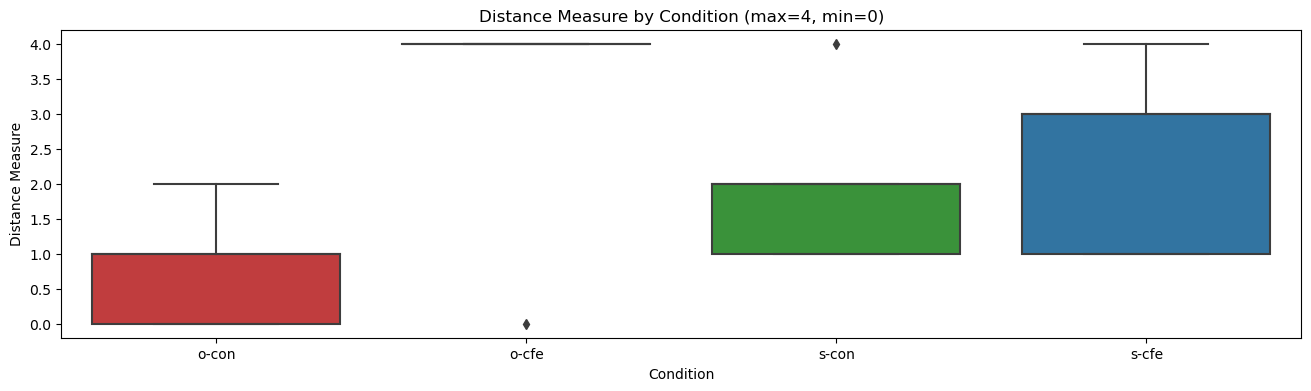

Kruskal-Wallis H Test for Distance Measure:
Statistic: 6.109, p-value: 0.106


In [23]:
# Filter to keep only rows where itemNo == 1 and checked == 1
survey_data_importance = survey_data_cleaned[(survey_data_cleaned['itemNo'] == 1) & (survey_data_cleaned['checked'] == 1)]

# Drop duplicate rows based on userID, keeping only the first occurrence
survey_data_importance = survey_data_importance.drop_duplicates(subset='userID')

# Define a function to transform the values into "high", "medium", and "low" based on quantiles
def transform_quantile_ranking(row):
    scores = [
        row['importanceQuality'],
        row['importanceProductivity'],
        row['importancePunctuality'],
        row['importanceFeedback']
    ]
    high_threshold = pd.Series(scores).quantile(0.66)
    low_threshold = pd.Series(scores).quantile(0.33)
    return [
        'high' if score > high_threshold else 'medium' if score > low_threshold else 'low' 
        for score in scores
    ]

# Apply the transformation to the relevant columns using assign
rankings = survey_data_importance.apply(transform_quantile_ranking, axis=1)
rankings_df = pd.DataFrame(rankings.tolist(), columns=['Quality', 'Productivity', 'Punctuality', 'Feedback'])

survey_data_importance = pd.concat([survey_data_importance.reset_index(drop=True), rankings_df], axis=1)

# Compute the distance measure based on the specified criteria
def compute_distance_measure(row):
    score = 0
    if row['Quality'] == 'high':
        score += 1
    if row['Productivity'] == 'high':
        score += 1
    if row['Punctuality'] == 'medium':
        score += 1
    if row['Feedback'] == 'low':
        score += 1
    return score

# Apply the function to compute the distance measure
survey_data_importance['distance_measure'] = survey_data_importance.apply(compute_distance_measure, axis=1)

# Visualize box plots per group for the distance_measure
plt.figure(figsize=(16, 4))
sns.boxplot(data=survey_data_importance, x='cond', y='distance_measure',palette=color_palette)
plt.title('Distance Measure by Condition (max=4, min=0)')
plt.xlabel('Condition')
plt.ylabel('Distance Measure')
plt.show()

# Perform a Kruskal-Wallis H test for statistical comparison
groups = [survey_data_importance[survey_data_importance['cond'] == cond]['distance_measure'] for cond in survey_data_importance['cond'].unique()]
kruskal_test_result = kruskal(*groups)

print("Kruskal-Wallis H Test for Distance Measure:")
print(f"Statistic: {round(kruskal_test_result.statistic,3)}, p-value: {round(kruskal_test_result.pvalue,3)}")

# Perform Dunn's test for post hoc comparisons if Kruskal-Wallis test is significant
if kruskal_test_result.pvalue < 0.05:
    posthoc_result = sp.posthoc_dunn(survey_data_importance, val_col='distance_measure', group_col='cond', p_adjust='bonferroni')
    print("Post Hoc Comparisons using Dunn's Test with Bonferroni Correction:")
    print(round(posthoc_result,3))


### B. Analyze Survey Responses Regarding Satisfaction and Trust

#### Satisfaction

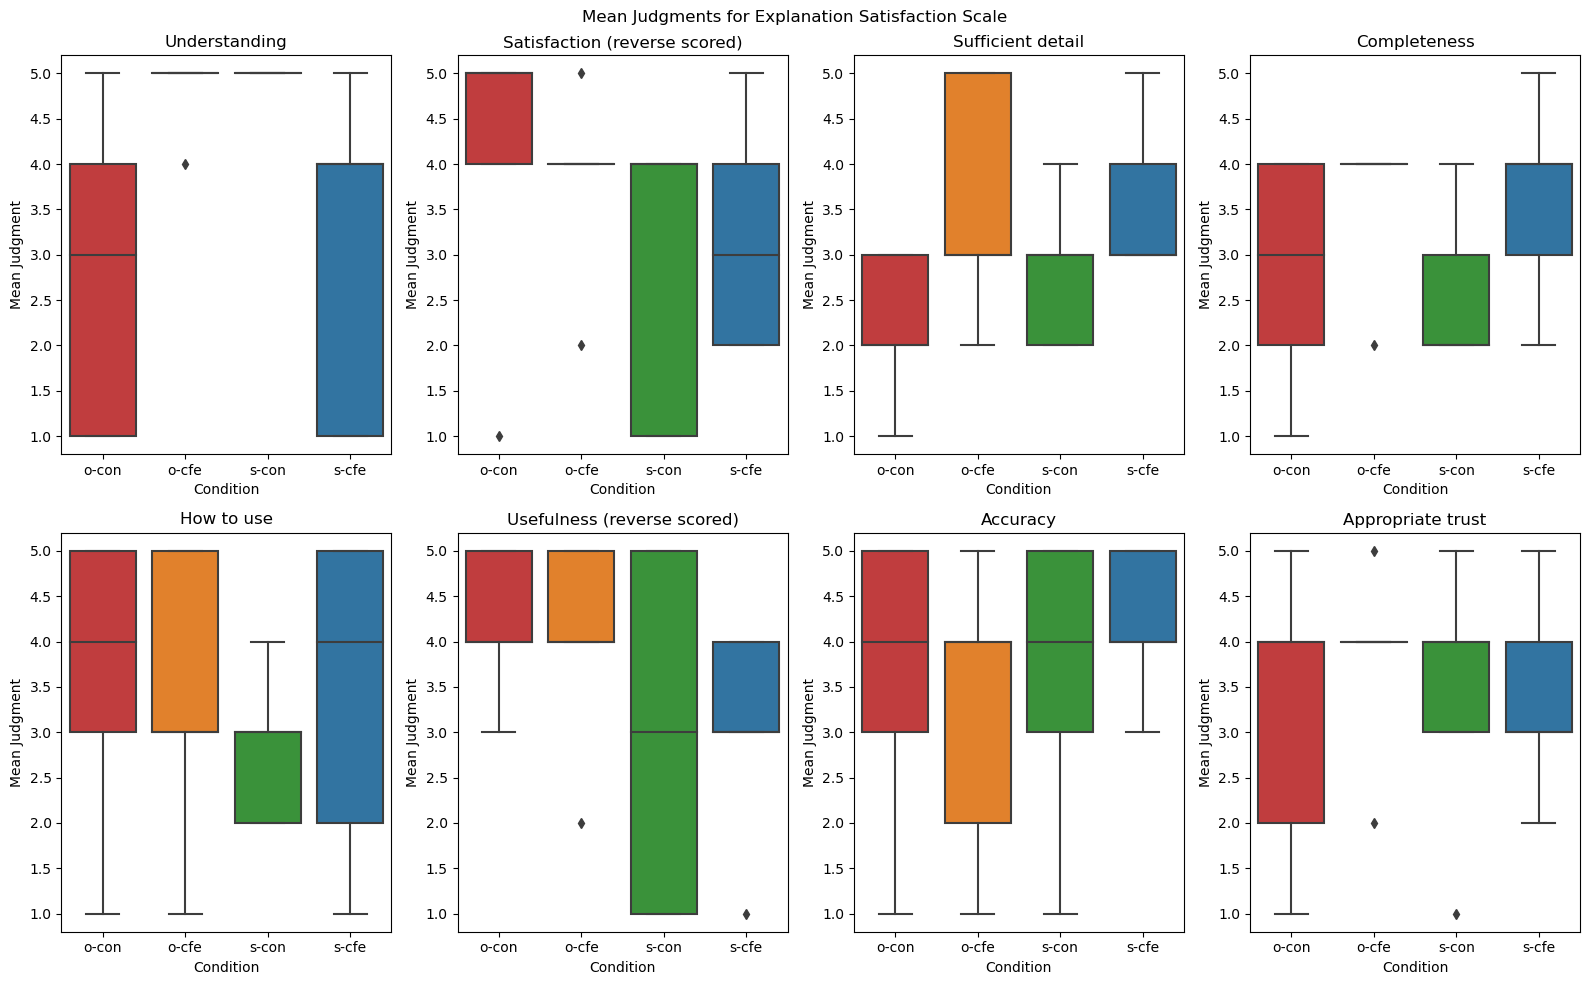

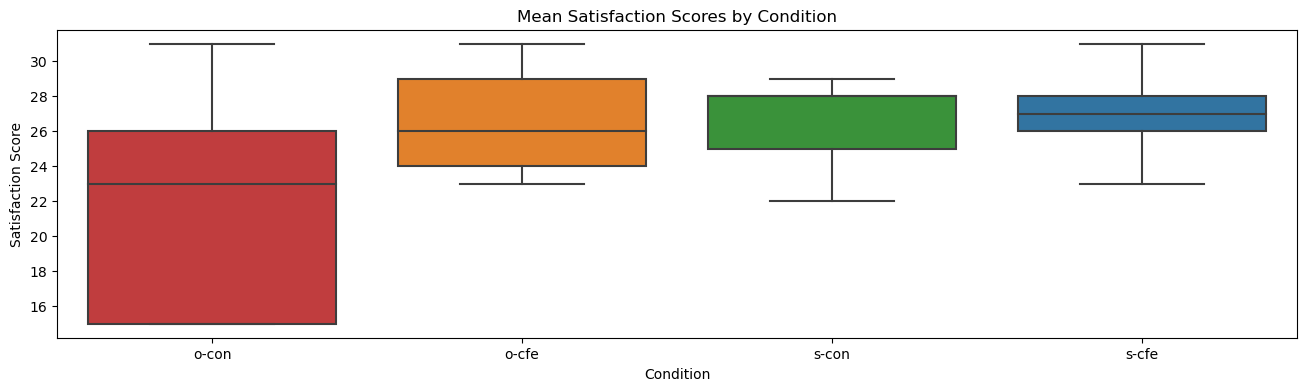

Kruskal-Wallis H Test for Satisfaction Scores:
Statistic: 0.792, p-value: 0.851


In [26]:
# Filter only rows where checked == 1
survey_data_checked = survey_data_cleaned[survey_data_cleaned['checked'] == 1]

# Define the items for Explanation Satisfaction Scale and Explanation Trust Scale
satisfaction_items = [0, 1, 2, 3, 4, 6, 7, 8] #[1, 2, 3, 4, 5, 7, 8, 9] 
trust_items = [9, 10, 11, 12, 13, 14, 15, 16]

# Define labels for the plots
satisfaction_labels = {
    0: 'Understanding', 1: 'Satisfaction (reverse scored)', 2: 'Sufficient detail', 3: 'Completeness',
    4: 'How to use', 6: 'Usefulness (reverse scored)', 7: 'Accuracy', 8: 'Appropriate trust'
}

trust_labels = {
    9: 'Confidence (reverse scored)', 10: 'Predictability', 11: 'Reliance', 12: 'Fair Evaluation (reverse scored)',
    13: 'Efficiency', 14: 'Wariness (reverse scored)', 15: 'Improvement over human performance', 16: 'Liking of system'} ##, 17: 'Liking of system}

# Plot average judgments per group for Explanation Satisfaction Scale
plt.figure(figsize=(16, 10))
for i, item in enumerate(satisfaction_items, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(data=survey_data_checked[survey_data_checked['itemNo'] == item], x='cond', y='responseNo',palette=color_palette)
    plt.title(satisfaction_labels[item])
    plt.xlabel('Condition')
    plt.ylabel('Mean Judgment')
plt.suptitle('Mean Judgments for Explanation Satisfaction Scale')
plt.tight_layout()
plt.show()

# Recode reverse scored items
survey_data_checked = survey_data_checked.assign(
    response_recode=survey_data_checked['responseNo']
)
############
### TO DO: CORRECT REVERSE CODE ITEM NUMBERS (Logging mismatch?)
survey_data_checked.loc[survey_data_checked['itemNo'].isin([1, 6, 9, 12, 14]), 'response_recode'] = 6 - survey_data_checked['responseNo']
############

# Compute summed scores for satisfaction and trust scales
satisfaction_scores = survey_data_checked[survey_data_checked['itemNo'].isin(satisfaction_items)].groupby('userID')['response_recode'].sum()
trust_scores = survey_data_checked[survey_data_checked['itemNo'].isin(trust_items)].groupby('userID')['response_recode'].sum()

# Add summed scores to the original DataFrame
survey_data_checked = survey_data_checked.merge(satisfaction_scores.rename('satisfaction_score'), on='userID')
survey_data_checked = survey_data_checked.merge(trust_scores.rename('trust_score'), on='userID')

# Plot mean satisfaction scores per group
plt.figure(figsize=(16, 4))
sns.boxplot(data=survey_data_checked, x='cond', y='satisfaction_score',palette=color_palette)
plt.title('Mean Satisfaction Scores by Condition')
plt.xlabel('Condition')
plt.ylabel('Satisfaction Score')
plt.show()

# Run statistical tests for satisfaction scale
satisfaction_groups = [survey_data_checked[survey_data_checked['cond'] == cond]['satisfaction_score'].unique() for cond in survey_data_checked['cond'].unique()]
satisfaction_kruskal = kruskal(*satisfaction_groups)

print("Kruskal-Wallis H Test for Satisfaction Scores:")
print(f"Statistic: {round(satisfaction_kruskal.statistic,3)}, p-value: {round(satisfaction_kruskal.pvalue,3)}")

# Perform Dunn's test for post hoc comparisons if Kruskal-Wallis tests are significant
if satisfaction_kruskal.pvalue < 0.05:
    satisfaction_posthoc = sp.posthoc_dunn(survey_data_checked, val_col='satisfaction_score', group_col='cond', p_adjust='bonferroni')
    print("\nPost Hoc Comparisons for Satisfaction Scores using Dunn's Test with Bonferroni Correction:")
    print(round(satisfaction_posthoc,3))

#### Trust

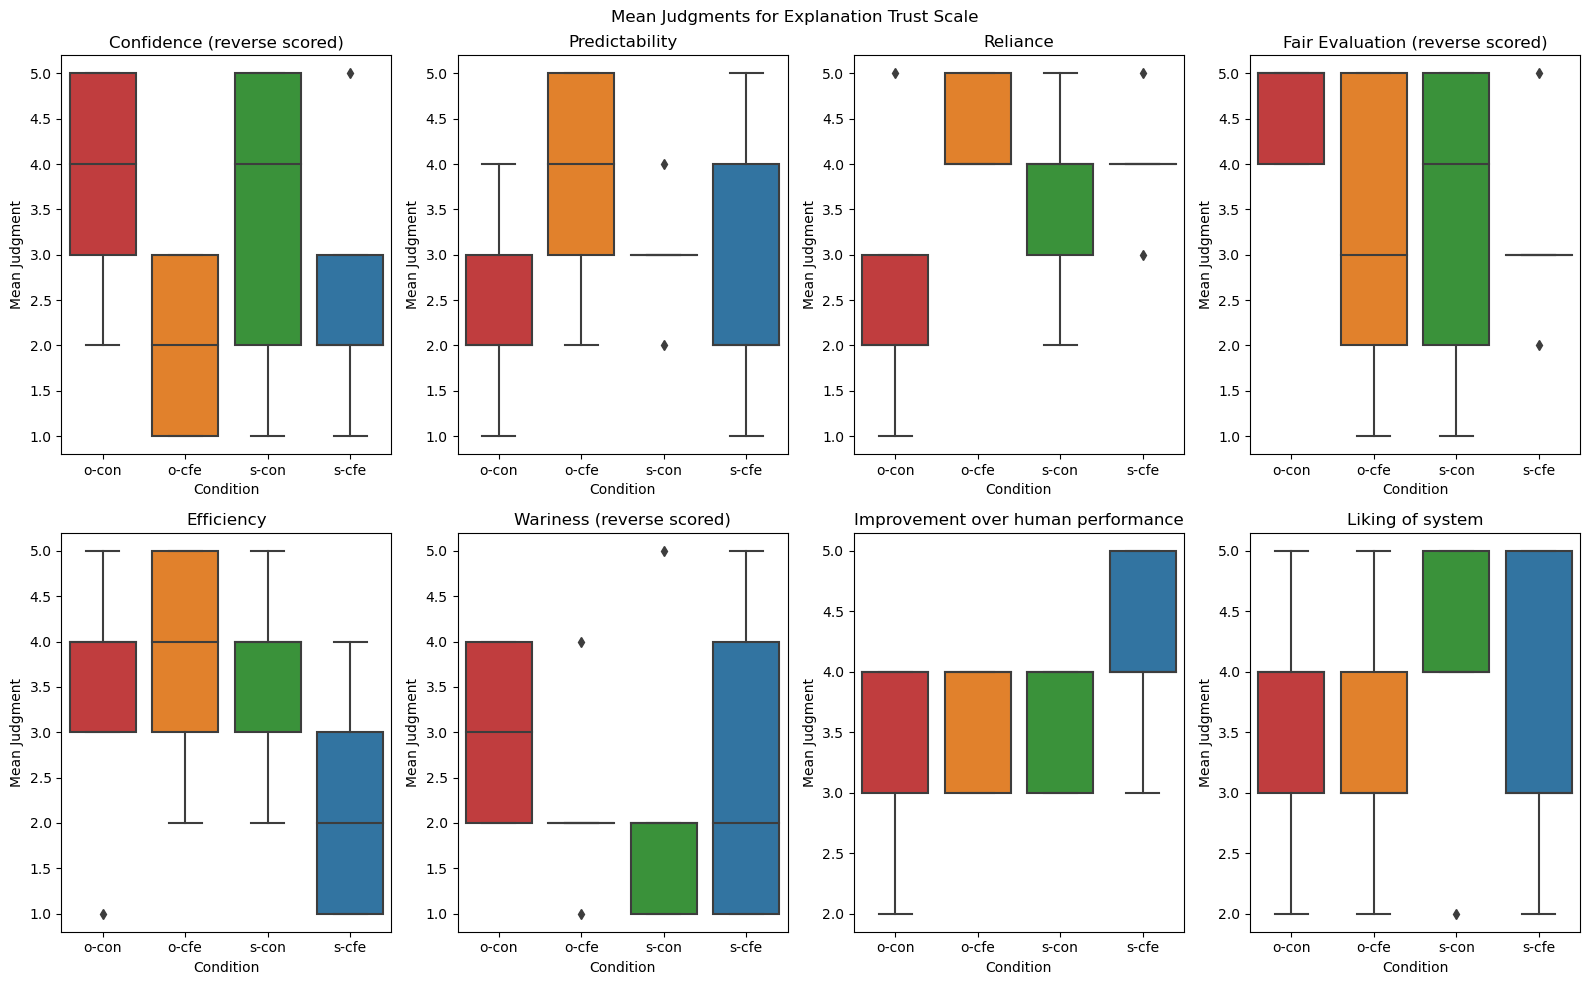

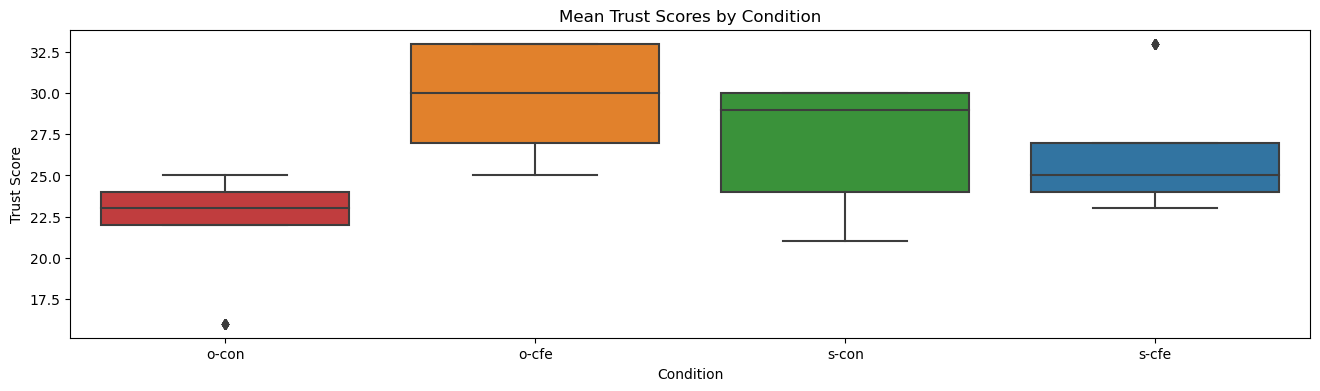


Kruskal-Wallis H Test for Trust Scores:
Statistic: 6.275, p-value: 0.099


In [30]:
# Plot average judgments per group for Explanation Trust Scale
plt.figure(figsize=(16, 10))
for i, item in enumerate(trust_items, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(data=survey_data_checked[survey_data_checked['itemNo'] == item], x='cond', y='responseNo',palette=color_palette)
    plt.title(trust_labels[item])
    plt.xlabel('Condition')
    plt.ylabel('Mean Judgment')
plt.suptitle('Mean Judgments for Explanation Trust Scale')
plt.tight_layout()
plt.show()

# Plot mean trust scores per group
plt.figure(figsize=(16, 4))
sns.boxplot(data=survey_data_checked, x='cond', y='trust_score',palette=color_palette)
plt.title('Mean Trust Scores by Condition')
plt.xlabel('Condition')
plt.ylabel('Trust Score')
plt.show()

# Run statistical tests for satisfaction scale
trust_groups = [survey_data_checked[survey_data_checked['cond'] == cond]['trust_score'].unique() for cond in survey_data_checked['cond'].unique()]
trust_kruskal = kruskal(*trust_groups)

print("\nKruskal-Wallis H Test for Trust Scores:")
print(f"Statistic: {round(trust_kruskal.statistic,3)}, p-value: {round(trust_kruskal.pvalue,3)}")

if trust_kruskal.pvalue < 0.05:
    trust_posthoc = sp.posthoc_dunn(survey_data_checked, val_col='trust_score', group_col='cond', p_adjust='bonferroni')
    print("\nPost Hoc Comparisons for Trust Scores using Dunn's Test with Bonferroni Correction:")
    print(round(trust_posthoc,3))